In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pytrends.request import TrendReq
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
df = pd.read_csv('W3_AAPL_quarterly_financials.csv', 
                 sep = ",", 
                 index_col = 0)
df = df.T
df.drop(['ttm'],inplace=True)
df_mt = df[['BasicEPS']]
df_mt.fillna(method="backfill",inplace=True)
df_mt.fillna(0,inplace=True)
df_mt.index = pd.to_datetime(df_mt.index)
df_mt.sort_index(inplace=True,ascending=True)
eps_data = df_mt


/var/folders/l_/pnhpmj9j5bv0nkj97f4pfm3m0000gn/T/ipykernel_6297/3132197018.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_mt.fillna(method="backfill",inplace=True)
/var/folders/l_/pnhpmj9j5bv0nkj97f4pfm3m0000gn/T/ipykernel_6297/3132197018.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mt.fillna(method="backfill",inplace=True)
/var/folders/l_/pnhpmj9j5bv0nkj97f4pfm3m0000gn/T/ipykernel_6297/3132197018.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mt.fillna(0,inplace=True)
/var/folders/l_/pnhpmj9j5bv0nkj97f

# 1.) Import data. Train, Test, Holdout (80%,15%,5%)

In [3]:
train_eps,test_eps = train_test_split(eps_data,train_size=0.80,test_size=0.10)


# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [4]:
pytrends = TrendReq(hl='en-US', tz=360)


relevant_keywords = ['iphone','Starbucks','sports','MagSafe','Thanksgiving', 'dollar']
irrelevant_keywords = ['Uhaul','Bumblebee','Mustang']


keywords = relevant_keywords + irrelevant_keywords


start_date = '2004-01-01'
end_date = '2024-01-01'


df = pd.DataFrame()


for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]
df.fillna(method="backfill",inplace=True)


/var/folders/l_/pnhpmj9j5bv0nkj97f4pfm3m0000gn/T/ipykernel_6297/4118444807.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="backfill",inplace=True)


# 3.) Normalize all the X data

In [5]:
eps_data = eps_data.astype(float)
eps_data = eps_data.resample("Q").mean()["2004-01-01":]
df = df.resample('Q').mean()[:"2023-9-30"]
display("data scale: ",df.shape,eps_data.shape)
scalar = StandardScaler()

X_std = scalar.fit_transform(df)
display(pd.DataFrame(X_std,index=df.index,columns=df.columns).head())
#y = scalar.fit_transform(eps_data)
y = eps_data.values

'data scale: '

(79, 9)

(79, 1)

,iphone,Starbucks,sports,MagSafe,Thanksgiving,dollar,Uhaul,Bumblebee,Mustang
date,,,,,,,,,
2004-03-31,-1.826957,-1.604503,1.689561,-0.541184,-0.665306,-1.246496,-1.122667,-0.715891,2.897751
2004-06-30,-1.826957,-1.570419,1.412210,-0.592944,-0.665306,-1.322464,0.476745,-0.617790,2.809985
2004-09-30,-1.826957,-1.468170,1.446879,-0.592944,-0.495916,-1.360448,0.520565,-0.470638,2.078604
2004-12-31,-1.826957,-1.314795,1.724230,-0.558438,1.802942,-1.113553,-0.903570,-0.568739,3.336579
2005-03-31,-1.826957,-1.382961,1.689561,-0.592944,-0.665306,-0.809682,-0.859750,-0.666841,2.927006


# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

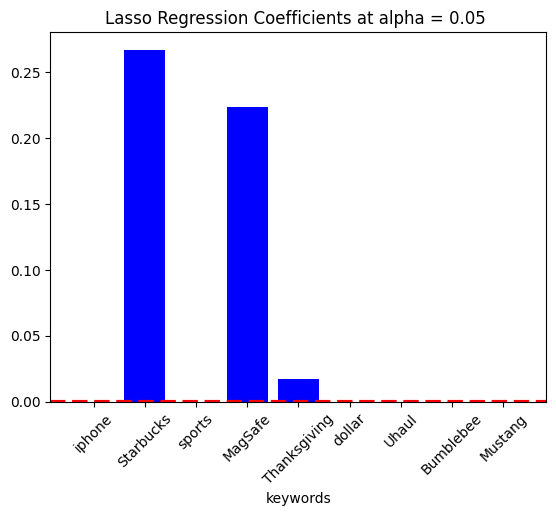

Lasso regression score: 0.05  0.9148583637209775
                  coef
iphone        0.000000
Starbucks     0.266853
sports       -0.000000
MagSafe       0.223226
Thanksgiving  0.016832
dollar        0.000000
Uhaul        -0.000000
Bumblebee     0.000000
Mustang      -0.000000


In [6]:
def run_lasso_regression(X, y, alpha):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    return lasso
alpha = 0.05
reg = run_lasso_regression(X_std,y,alpha)
plt.bar(range(len(reg.coef_)),
    reg.coef_,tick_label=df.columns,color= "blue")
plt.axhline(0, color='red', linestyle="--",linewidth=3)
plt.title("Lasso Regression Coefficients at alpha = {} ".format(alpha))
plt.xlabel("keywords")
plt.xticks(rotation=45)
plt.show()
reg.fit(X_std,y)
print("Lasso regression score: {} ".format(alpha),reg.score(X_std,y))
print(pd.DataFrame(reg.coef_,index=df.columns,columns=["coef"]))

# 5.) Do these coefficient magnitudes make sense?

Yes, the coefficients of the irrelevant words are close to zero, and the majority of the relevant words has a coefficient different from zero.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.229e-01, tolerance: 2.062e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

,score
0.00,0.939586
0.01,0.933933
0.05,0.914858
0.10,0.871033
0.20,0.722337
0.50,0.0
0.80,0.0
1.00,0.0
5.00,0.0
10.00,0.0


best lambda:  0.0


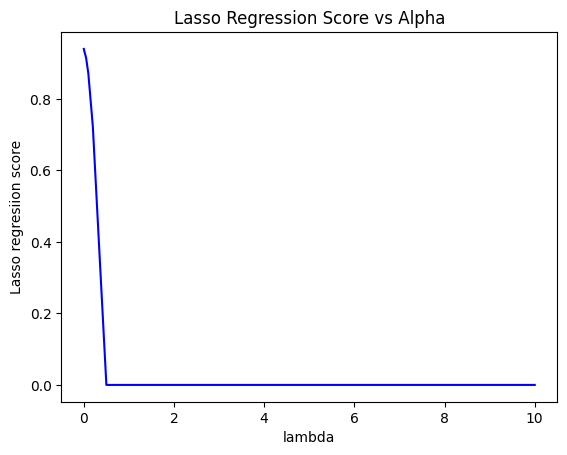

In [7]:
lambdas = [0,0.01,0.05,0.1,0.2,0.5,0.8,1,5,10]

scores = pd.DataFrame(columns=["score"], index = lambdas)
for l in lambdas:
    reg = run_lasso_regression(X_std,y,l)
    scores.loc[l] = reg.score(X_std,y)

plt.plot(scores.index,scores["score"],color="blue")
plt.title("Lasso Regression Score vs Alpha")
plt.xlabel("lambda")
plt.ylabel("Lasso regresiion score")
display(scores)
print("best lambda: ",scores[scores["score"] == scores["score"].max()].index.values[0])


# 7.) Run a cross validation. What is your ideal lambda?

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.275e-01, tolerance: 1.570e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

,score1,score2,score3,score4,score5,mean,std
0,-100.003005,0.606151,0.408133,0.318791,-17.325170,-23.199020,39.013909
0.01,-38.332157,0.702710,0.628686,0.432693,-2.055102,-7.724634,15.338214
0.05,-35.727572,0.573729,0.622597,0.345826,-2.489922,-7.335068,14.244152
0.1,-94.570417,-0.065642,0.537453,0.344772,-3.178687,-19.386504,37.616212
0.2,-469.724031,-2.500113,0.448572,0.151614,-5.058704,-95.336532,187.204412
0.5,-1511.669868,-14.569639,-0.105680,-0.756521,-6.167944,-306.653930,602.530253
0.8,-1511.669868,-14.569639,-0.246827,-0.658656,-6.167944,-306.662587,602.525832
1,-1511.669868,-14.569639,-0.246827,-0.658656,-6.167944,-306.662587,602.525832
5,-1511.669868,-14.569639,-0.246827,-0.658656,-6.167944,-306.662587,602.525832
10,-1511.669868,-14.569639,-0.246827,-0.658656,-6.167944,-306.662587,602.525832


best lambda:  0.05  with cross validation score:  -7.335068229615311


Text(0.5, 1.0, 'Lasso Regression Cross Validation Scores')

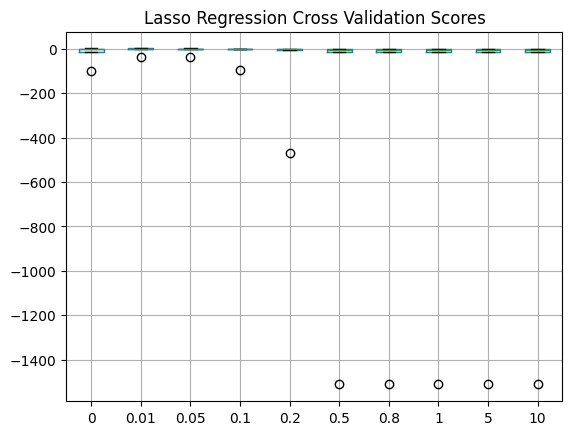

In [8]:
n = 5

scores_cross_validation = pd.DataFrame(columns=['score{}'.format(i) for i in range(1,n+1)])

for l in lambdas:
   lasso = Lasso(alpha=l)
   fit = cross_val_score(lasso, X_std, y, cv=n)
   scores_cross_validation.loc[str(l)] = fit
scores_cross_validation["mean"] = scores_cross_validation.mean(axis=1)
scores_cross_validation['std'] = scores_cross_validation.std(axis=1)
display(scores_cross_validation)


best_alpha = scores_cross_validation["mean"].idxmax()
print("best lambda: ",best_alpha," with cross validation score: ",scores_cross_validation.loc[best_alpha,"mean"])
scores_cross_validation.drop(["mean","std"],axis=1,inplace=True)
scores_cross_validation.T.boxplot().set_title("Lasso Regression Cross Validation Scores")
